In [51]:
import os
import numpy as np # to process the data
import random
import math
import matplotlib.pyplot as plt
from random import shuffle
from PIL import Image
from sklearn.model_selection import train_test_split

In [52]:
class FlowerDataset:
    def __init__(self, directory):
        self.directory = directory
        self.images = []
        self.labels = []

    def load_data(self):
        image_files = os.listdir(self.directory)
        for img in image_files:
        # for img in image_files[:20]:
            try:
                img_path = os.path.join(self.directory, img)
                with Image.open(img_path) as img_array:
                    # Convert image to RGB
                    img_array = img_array.convert("RGB")
                    resized_array = img_array.resize((32, 32))
                    self.images.append(np.array(resized_array))
                    label = img.split('_')[0]
                    self.labels.append(label)
            except Exception as e:
                print(f"Error loading image {img}: {e}")

    def preprocess_data(self):
        max_pixel_value = 255.0
        self.images = [image / max_pixel_value for image in self.images]

    def print_dataset_dimensions(self):
        if self.images:
            print(f"Total number of images: {len(self.images)}")
            print(f"Dimensions of each image: {self.images[0].shape}")
            print(f"Total dimensions of the dataset (assuming all images have the same shape): {len(self.images)} x {self.images[0].shape}")
        else:
            print("The dataset is empty or not loaded properly.")

    def one_hot_encode(self):
        unique_labels = sorted(set(self.labels))
        label_to_int = {label: index for index, label in enumerate(unique_labels)}
        self.label_indices = [label_to_int[label] for label in self.labels]
        self.labels = [[int(i == label_index) for i in range(len(unique_labels))] for label_index in self.label_indices]

def split_data(images, labels, train_ratio, validation_ratio, test_ratio):
    combined = list(zip(images, labels))
    shuffle(combined)
    shuffled_images, shuffled_labels = zip(*combined)

    train_end = int(len(shuffled_images) * train_ratio)
    validation_end = train_end + int(len(shuffled_images) * validation_ratio)

    x_train = shuffled_images[:train_end]
    y_train = shuffled_labels[:train_end]
    x_val = shuffled_images[train_end:validation_end]
    y_val = shuffled_labels[train_end:validation_end]
    x_test = shuffled_images[validation_end:]
    y_test = shuffled_labels[validation_end:]

    return list(x_train), list(x_val), list(x_test), list(y_train), list(y_val), list(y_test)

# Usage
dataset = FlowerDataset('flowers')
dataset.load_data()
dataset.preprocess_data()
dataset.one_hot_encode()

x_train, x_val, x_test, y_train, y_val, y_test = split_data(dataset.images, dataset.labels, 0.75, 0.15, 0.10)

# Print the dimensions of the preprocessed images
dataset.print_dataset_dimensions()

# Print the sizes of the datasets
print(f"Train set size: {len(x_train)}, Validation set size: {len(x_val)}, Test set size: {len(x_test)}")

# Print the unique classes in the training set
unique_classes = sorted(set([label.index(1) for label in y_train]))
print(f"Unique classes in the training set: {unique_classes}")

num_classes = len(unique_classes)
print(f"Number of classes for prediction: {num_classes}")


Error loading image .ipynb_checkpoints: [Errno 21] Is a directory: '/storage/student14/phucpg/WORKSPACE/flowers/.ipynb_checkpoints'
Total number of images: 733
Dimensions of each image: (32, 32, 3)
Total dimensions of the dataset (assuming all images have the same shape): 733 x (32, 32, 3)
Train set size: 549, Validation set size: 109, Test set size: 75
Unique classes in the training set: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Number of classes for prediction: 10


In [53]:
class Limiting:
    @staticmethod
    def clip(value, min_value, max_value):
        return max(min(value, max_value), min_value)

    @staticmethod
    def min_max_scale(data):
        min_val = min(data)
        max_val = max(data)
        range_val = max_val - min_val
        if range_val == 0:
            return [0 for _ in data]  # Return a list of zeros if all values are the same
        scaled_data = [(value - min_val) / range_val for value in data]
        return scaled_data

In [54]:
# Base Layer class
class Layer:
    def forward(self, input_data):
        raise NotImplementedError

    def backward(self, output_error, learning_rate):
        raise NotImplementedError

# Convolutional Layer
class ConvLayer(Layer):
    def __init__(self, num_filters, filter_size, num_channels=3, padding=0, stride=1):
        self.num_filters = num_filters
        self.filter_size = filter_size
        self.filters = np.random.randn(num_filters, filter_size, filter_size, num_channels) / 9  # normalize values
        self.padding = padding
        self.stride = stride
        
    def forward(self, input_data):
        # Assert that the input data has the expected shape
        assert len(input_data.shape) == 4, f"Expected input shape to be 4D, got {input_data.shape}"
        # Ensure the input data has four dimensions: batch size, height, width, and depth
        if len(input_data.shape) < 4:
            input_data = np.expand_dims(input_data, axis=0)  # Add a batch dimension
        self.last_input = input_data
        batch_size, h, w, d = input_data.shape

        # Define input_padded here
        input_padded = np.pad(input_data, (
            (0, 0), 
            (self.padding, self.padding), 
            (self.padding, self.padding), 
            (0, 0)
        ), 'constant')

        new_h = int((h + 2 * self.padding - self.filter_size) / self.stride) + 1
        new_w = int((w + 2 * self.padding - self.filter_size) / self.stride) + 1
        output = np.zeros((batch_size, new_h, new_w, self.num_filters))

        for b in range(batch_size):
            for i in range(0, new_h):
                for j in range(0, new_w):
                    for f in range(self.num_filters):
                        # Compute the start and end indices once
                        h_start = i*self.stride
                        h_end = h_start+self.filter_size
                        w_start = j*self.stride
                        w_end = w_start+self.filter_size
    
                        output[b, i, j, f] = np.sum(
                            input_padded[b, h_start:h_end, w_start:w_end, :] * self.filters[f]
                        )
        return output

    def backward(self, output_error, learning_rate):
        d_filters = np.zeros(self.filters.shape)
        d_input = np.zeros(self.last_input.shape)
        batch_size, h_i, w_i, d_i = self.last_input.shape  # Add 'batch_size' here
    
        new_h = int((h_i + 2 * self.padding - self.filter_size) / self.stride) + 1
        new_w = int((w_i + 2 * self.padding - self.filter_size) / self.stride) + 1
    
        for b in range(batch_size):
            for i in range(0, new_h):
                for j in range(0, new_w):
                    for f in range(self.num_filters):
                        # Compute the start and end indices once
                        h_start = i*self.stride
                        h_end = h_start+self.filter_size
                        w_start = j*self.stride
                        w_end = w_start+self.filter_size
    
                        gradient_filters = output_error[b, i, j, f] * self.last_input[b, h_start:h_end, w_start:w_end]
                        d_filters[f] += gradient_filters
    
                        gradient_input = self.filters[f] * output_error[b, i, j, f]
                        d_input[b, h_start:h_end, w_start:w_end] += gradient_input
        self.filters -= learning_rate * d_filters
        return d_input

    def reset(self):
        self.last_input = None
        
# MaxPooling Layer
class MaxPoolingLayer(Layer):
    def __init__(self, pool_size):
        self.pool_size = pool_size

    def forward(self, input_data):
        self.last_input = input_data
        batch_size, h, w, num_filters = input_data.shape
        output = np.zeros((batch_size, h // self.pool_size, w // self.pool_size, num_filters))
        for b in range(batch_size):
            for i in range(h // self.pool_size):
                for j in range(w // self.pool_size):
                    for f in range(num_filters):
                        output[b, i, j, f] = np.max(input_data[b, i*self.pool_size:(i+1)*self.pool_size, j*self.pool_size:(j+1)*self.pool_size, f])
        return output

    def backward(self, output_error, learning_rate):
        d_input = np.zeros(self.last_input.shape)
        batch_size, h, w, num_filters = self.last_input.shape
    
        for b in range(batch_size):
            for i in range(h // self.pool_size):
                for j in range(w // self.pool_size):
                    for f in range(num_filters):
                        # Compute the start and end indices once
                        h_start = i * self.pool_size
                        h_end = h_start + self.pool_size
                        w_start = j * self.pool_size
                        w_end = w_start + self.pool_size
    
                        # Propagate the gradient to the max location
                        patch = self.last_input[b, h_start:h_end, w_start:w_end, f]
                        max_index = np.argmax(patch)
                        max_coord = np.unravel_index(max_index, patch.shape)
                        d_input[b, h_start + max_coord[0], w_start + max_coord[1], f] = output_error[b, i, j, f]
    
        return d_input
        
class FlattenLayer(Layer):
    def forward(self, input_data):
        self.last_input_shape = input_data.shape
        return input_data.reshape(input_data.shape[0], -1)
        
    def backward(self, output_error, learning_rate):
        return output_error.reshape(self.last_input_shape)
        
# Dropout Layer
class DropoutLayer(Layer):
    def __init__(self, dropout_rate):
        self.dropout_rate = dropout_rate

    def forward(self, input_data):
        self.mask = (np.random.rand(*input_data.shape) > self.dropout_rate) / (1.0 - self.dropout_rate)
        return input_data * self.mask

    def backward(self, output_error, learning_rate):
        return output_error * self.mask

# Dense Layer
class DenseLayer(Layer):
    def __init__(self, input_size, output_size):
        self.weights = np.random.randn(input_size, output_size) * np.sqrt(2. / input_size)
        self.biases = np.zeros(output_size)  # Ensure biases is a 1D array with length 'output_size'
        
    def forward(self, input_data):
        # Assert that the input data is 2D after flattening
        assert len(input_data.shape) == 2, f"Expected input shape to be 2D, got {input_data.shape}"
        self.last_input = input_data
        return np.dot(input_data, self.weights) + self.biases
    
    def backward(self, output_error, learning_rate):
        d_weights = np.outer(self.last_input, output_error)
        d_biases = np.sum(output_error, axis=0)  # Sum over the batch dimension
        learning_rate_d_weights = learning_rate * d_weights
        learning_rate_d_biases = learning_rate * d_biases
        self.weights -= learning_rate_d_weights
        self.biases -= learning_rate_d_biases
        return np.dot(output_error, self.weights.T)
        
class SoftmaxLayer(Layer):
    def forward(self, input_data):
        # Reshape input_data to 2D if it's 1D
        if input_data.ndim == 1:
            input_data = input_data.reshape(1, -1)

        input_data = np.clip(input_data, -1e2, 1e2)  # Clip values to a reasonable range
        exp = np.exp(input_data - np.max(input_data, axis=1, keepdims=True))
        return exp / np.sum(exp, axis=1, keepdims=True)

    def backward(self, output_error, learning_rate):
        return output_error  # Error is passed straight through to the next layer
        
# ReLU Activation
class ReLULayer(Layer):
    def forward(self, input_data):
        self.last_input = input_data
        return np.maximum(0, input_data)

    def backward(self, output_error, learning_rate):
        # The derivative of ReLU is 1 for positive inputs and 0 for negative inputs
        return output_error * (self.last_input > 0)

# Cross-Entropy Loss
class CrossEntropyLoss:
    def calculate_loss(self, predicted, actual):
        # Convert 'actual' to a NumPy array once before training
        predicted = np.clip(predicted, 1e-9, 1 - 1e-9)
        return -np.sum(actual * np.log(predicted)) # add small constant to avoid log(0)
        
    def calculate_gradient(self, predicted, actual):
        # Convert 'actual' to a NumPy array if it's a list
        actual = np.array(actual) if isinstance(actual, list) else actual
    
        # Ensure 'actual' is a 2D array with the same shape as 'predicted'
        if actual.ndim == 1:
            actual = actual.reshape(1, -1)
        return predicted - actual

In [55]:
class CNN:
    def __init__(self, num_classes, epochs=10, learning_rate=0.001, threshold=0.5, early_stopping_patience=5):
        self.layers = [
            ConvLayer(num_filters=32, filter_size=3, num_channels=3),  # num_channels is 3 for RGB images
            ReLULayer(),
            MaxPoolingLayer(pool_size=2),
            ConvLayer(num_filters=64, filter_size=3, num_channels=32),  # num_channels is num_filters of previous ConvLayer
            ReLULayer(),
            MaxPoolingLayer(pool_size=2),
            ConvLayer(num_filters=128, filter_size=3, num_channels=64),  # num_channels is num_filters of previous ConvLayer
            ReLULayer(),
            MaxPoolingLayer(pool_size=2),
            # ConvLayer(num_filters=256, filter_size=3, num_channels=128),  # num_channels is num_filters of previous ConvLayer
            # ReLULayer(),
            # MaxPoolingLayer(pool_size=2),
            # ConvLayer(num_filters=512, filter_size=3, num_channels=256),  # num_channels is num_filters of previous ConvLayer
            # ReLULayer(),
            # MaxPoolingLayer(pool_size=2),
            FlattenLayer(),
            # None, # -6   # Placeholder for first DenseLayer, will initialize properly later
            # ReLULayer(),
            # DropoutLayer(dropout_rate=0.5),
            None, # -3   # Placeholder for second DenseLayer, will initialize properly later
            ReLULayer(),
            DropoutLayer(dropout_rate=0.5),
            None, # -1   # Placeholder for third DenseLayer, will initialize properly later
            SoftmaxLayer()
        ] 
        self.loss = CrossEntropyLoss()
        self.num_classes = num_classes
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.threshold = threshold
        self.early_stopping_patience = early_stopping_patience
        self.best_loss = np.inf
        self.patience_counter = 0

    def forward(self, X):
        for layer in self.layers:
            if layer is not None:
                # Ensure X is a NumPy array
                if isinstance(X, list):
                    X = np.array(X)
                # print(f"+ Before forward - {type(layer).__name__}: {X.shape}")
                X = layer.forward(X)
                # print(f"- After forward - {type(layer).__name__}: {X.shape}")
        return X

    def backward(self, output_error, learning_rate):
        for layer in reversed(self.layers):
            if layer is not None:
                # print(f"+ Before backward - {type(layer).__name__}: {output_error.shape}")
                output_error = layer.backward(output_error, learning_rate)
                # print(f"- After backward - {type(layer).__name__}: {output_error.shape}")

    def reset(self):
        for layer in self.layers:
            if hasattr(layer, 'last_input'):
                layer.last_input = None

    def validate(self, X_val, y_val):
        val_losses = []
        val_accuracies = []
    
        # Iterate over each example in the validation set
        for i in range(len(X_val)):
            # Forward pass
            input_data = np.expand_dims(X_val[i], axis=0)  # Add a batch dimension
            output = self.forward(input_data)
    
            # Calculate loss and accuracy for the current validation example
            val_loss = self.loss.calculate_loss(output, y_val[i])
            val_losses.append(val_loss)
            val_accuracy = (np.argmax(output, axis=1) == y_val[i]).mean()
            val_accuracies.append(val_accuracy)
    
        # Calculate average loss and accuracy over the entire validation set
        avg_val_loss = np.mean(val_losses)
        avg_val_accuracy = np.mean(val_accuracies)
    
        return avg_val_loss, avg_val_accuracy
    
    def calculate_loss(self, X, y):
        return self.loss.calculate_loss(X, y)

    def calculate_accuracy(self, X, y):
        predictions = self.predict(X)
        return np.mean(predictions == y)

    def min_max_scale(self, data):
        min_val = min(data)
        max_val = max(data)
        range_val = max_val - min_val
        if range_val == 0:
            return [0 for _ in data]  # Return a list of zeros if all values are the same
        scaled_data = [(value - min_val) / range_val for value in data]
        return scaled_data

    def train(self, X_train, y_train, X_val, y_val):
        print(f"Initial training data shape: {X_train[0].shape}\n")
        
        # Calculate the output size after the convolution and pooling layers
        sample_output = self.forward(np.expand_dims(X_train[0], axis=0))
        flattened_size = sample_output.size
        
        # Initialize the DenseLayers with the correct input size
        # self.layers[-6] = DenseLayer(input_size=flattened_size, output_size=128)  # First DenseLayer
        # self.layers[-3] = DenseLayer(input_size=128, output_size=64)  # Second DenseLayer
        # self.layers[-1] = DenseLayer(input_size=64, output_size=self.num_classes)  # Third DenseLayer

        self.layers[-3] = DenseLayer(input_size=flattened_size, output_size=128)  # Second DenseLayer
        self.layers[-2] = DenseLayer(input_size=128, output_size=self.num_classes)  # Third DenseLayer

        print("\n  |====== Start training ======| \n")

        train_losses = []
        train_accuracies = []
        val_losses = []
        val_accuracies = []
        
        for epoch in range(self.epochs):
            batch_losses = []
            batch_accuracies = []
            

            # print(f"Epoch {epoch} - Total number of rounds: {len(X_train)}")
            
            
            for j in range(len(X_train)):
                # print(f"\n=== start round {j}/{len(X_train)-1}/{epoch} ===\n")
                
                # forward
                input_data = np.expand_dims(X_train[j], axis=0)  # Add a batch dimension
                output = self.forward(input_data)

                # print("---------------------------------------")
                
                # backward
                output_error = self.loss.calculate_gradient(output, y_train[j])
                output_error = self.backward(output_error, self.learning_rate)
                                
                # Calculate loss and accuracy after the backward pass
                batch_loss = self.loss.calculate_loss(output, y_train[j])
                batch_losses.append(batch_loss)
                batch_accuracy = (np.argmax(output, axis=1) == y_train[j]).mean()
                batch_accuracies.append(batch_accuracy)
            
                self.reset()  # Reset the network's state after each forward pass
                # print(f"\n=== end round {j}/{len(X_train)-1}/{epoch} ===\n")

            # print(f"\n=== end epoch {epoch} ===\n")
            
            # Calculate the average training loss and accuracy for the epoch
            avg_train_loss = np.mean(batch_losses)
            # avg_train_loss = self.min_max_scale(avg_train_loss)
            avg_train_accuracy = np.mean(batch_accuracies)
            # avg_train_accuracy = self.min_max_scale(avg_train_accuracy)

            # Append the average metrics to the lists that track them across epochs
            train_losses.append(avg_train_loss)
            train_accuracies.append(avg_train_accuracy)
            
            self.reset()

            # Validation step
            val_loss, val_accuracy = self.validate(X_val, y_val)
            # val_loss = self.min_max_scale(val_loss)
            # val_accuracy = self.min_max_scale(val_accuracy)
            val_losses.append(val_loss)
            val_accuracies.append(val_accuracy)
            
            print(f"Epoch: {epoch}, Train Loss: {avg_train_loss}, Train Accuracy: {avg_train_accuracy}, Val Loss: {val_loss}, Val Accuracy: {val_accuracy}")
    
            if val_loss < self.best_loss:
                self.best_loss = val_loss
                self.patience_counter = 0
            else:
                self.patience_counter += 1
            if self.patience_counter >= self.early_stopping_patience:
                print("Early stopping due to no improvement in validation loss.")
                break

        print("Training finished.")
        print(f"Best validation accuracy achieved: {self.best_loss}")

        print()
        print("train_losses:", train_losses)
        print("train_accuracies:", train_accuracies)
        print("val_losses:", val_losses)
        print("val_accuracies:", val_accuracies)
        print()
        self.plot_results(train_losses, train_accuracies, val_losses, val_accuracies)

    def predict(self, X):
        predictions = []
        for i in range(len(X)):
            # Ensure the input data has four dimensions: batch size, height, width, and depth
            input_data = np.expand_dims(X[i], axis=0)  # Add a batch dimension
            output = self.forward(input_data)
            predictions.append(np.argmax(output, axis=1))  # Use axis=1 to get the class index
        return np.array(predictions)
    
    def plot_results(self, train_losses, train_accuracies, val_losses, val_accuracies):
        actual_epochs = min(len(train_losses), len(train_accuracies), len(val_losses), len(val_accuracies))
        assert actual_epochs > 0, "No data to plot."
    
        # If 'val_losses' is a nested list, flatten it
        if isinstance(val_losses[0], list):
            val_losses = [loss for sublist in val_losses for loss in sublist]
        
        epochs = range(1, actual_epochs + 1)
    
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(epochs, train_losses[:actual_epochs], 'g', label='Training loss')
        plt.plot(epochs, val_losses[:actual_epochs], 'b', label='Validation loss')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
    
        plt.subplot(1, 2, 2)
        plt.plot(epochs, train_accuracies[:actual_epochs], 'g', label='Training accuracy')
        plt.plot(epochs, val_accuracies[:actual_epochs], 'b', label='Validation accuracy')
        plt.title('Training and Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
    
        plt.tight_layout()
        plt.show()


Initial training data shape: (32, 32, 3)


  |====== Start training ======| 



/storage/student14/phucpg/venv/lib/python3.11/site-packages/numpy/core/numeric.py:925: RuntimeWarning: overflow encountered in multiply
  return multiply(a.ravel()[:, newaxis], b.ravel()[newaxis, :], out)
/tmp/ipykernel_1469954/97586717.py:72: RuntimeWarning: invalid value encountered in multiply
  gradient_filters = output_error[b, i, j, f] * self.last_input[b, h_start:h_end, w_start:w_end]
/tmp/ipykernel_1469954/97586717.py:76: RuntimeWarning: invalid value encountered in add
  d_input[b, h_start:h_end, w_start:w_end] += gradient_input
/tmp/ipykernel_1469954/97586717.py:183: RuntimeWarning: invalid value encountered in multiply
  return output_error * (self.last_input > 0)
/tmp/ipykernel_1469954/97586717.py:75: RuntimeWarning: invalid value encountered in multiply
  gradient_input = self.filters[f] * output_error[b, i, j, f]


Epoch: 0, Train Loss: nan, Train Accuracy: 0.8934426229508199, Val Loss: nan, Val Accuracy: 0.9000000000000005
Epoch: 1, Train Loss: nan, Train Accuracy: 0.9000000000000002, Val Loss: nan, Val Accuracy: 0.9000000000000005
Training finished.
Best validation accuracy achieved: inf

train_losses: [nan, nan]
train_accuracies: [0.8934426229508199, 0.9000000000000002]
val_losses: [nan, nan]
val_accuracies: [0.9000000000000005, 0.9000000000000005]



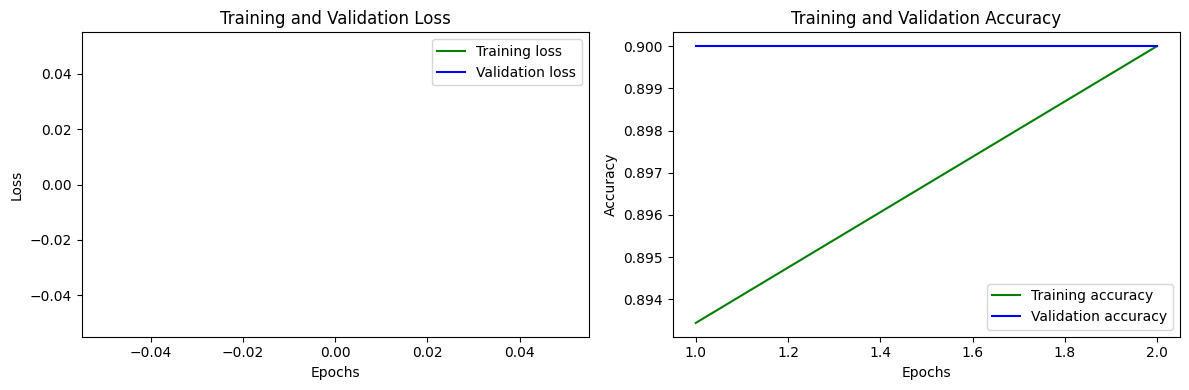

In [56]:
# Adjust the values to train
num_classes = num_classes
epochs = 2
learning_rate = 0.05
threshold = 0.5
early_stopping_patience = 5

cnn = CNN(num_classes, epochs, learning_rate, threshold, early_stopping_patience)
cnn.train(x_train, y_train, x_val, y_val)

Initial training data shape: (32, 32, 3)


  |====== Start training ======| 



/tmp/ipykernel_1469954/97586717.py:72: RuntimeWarning: overflow encountered in multiply
  gradient_filters = output_error[b, i, j, f] * self.last_input[b, h_start:h_end, w_start:w_end]
/tmp/ipykernel_1469954/97586717.py:75: RuntimeWarning: overflow encountered in multiply
  gradient_input = self.filters[f] * output_error[b, i, j, f]
/tmp/ipykernel_1469954/97586717.py:76: RuntimeWarning: invalid value encountered in add
  d_input[b, h_start:h_end, w_start:w_end] += gradient_input
/tmp/ipykernel_1469954/97586717.py:76: RuntimeWarning: overflow encountered in add
  d_input[b, h_start:h_end, w_start:w_end] += gradient_input
/tmp/ipykernel_1469954/97586717.py:183: RuntimeWarning: invalid value encountered in multiply
  return output_error * (self.last_input > 0)
/tmp/ipykernel_1469954/97586717.py:72: RuntimeWarning: invalid value encountered in multiply
  gradient_filters = output_error[b, i, j, f] * self.last_input[b, h_start:h_end, w_start:w_end]
/tmp/ipykernel_1469954/97586717.py:50: Run

Epoch: 0, Train Loss: nan, Train Accuracy: 0.6428051001821495, Val Loss: nan, Val Accuracy: 0.9000000000000005
Epoch: 1, Train Loss: nan, Train Accuracy: 0.9000000000000002, Val Loss: nan, Val Accuracy: 0.9000000000000005
Epoch: 2, Train Loss: nan, Train Accuracy: 0.9000000000000002, Val Loss: nan, Val Accuracy: 0.9000000000000005
Epoch: 3, Train Loss: nan, Train Accuracy: 0.9000000000000002, Val Loss: nan, Val Accuracy: 0.9000000000000005
Epoch: 4, Train Loss: nan, Train Accuracy: 0.9000000000000002, Val Loss: nan, Val Accuracy: 0.9000000000000005
Epoch: 5, Train Loss: nan, Train Accuracy: 0.9000000000000002, Val Loss: nan, Val Accuracy: 0.9000000000000005
Epoch: 6, Train Loss: nan, Train Accuracy: 0.9000000000000002, Val Loss: nan, Val Accuracy: 0.9000000000000005
Epoch: 7, Train Loss: nan, Train Accuracy: 0.9000000000000002, Val Loss: nan, Val Accuracy: 0.9000000000000005
Epoch: 8, Train Loss: nan, Train Accuracy: 0.9000000000000002, Val Loss: nan, Val Accuracy: 0.9000000000000005
E

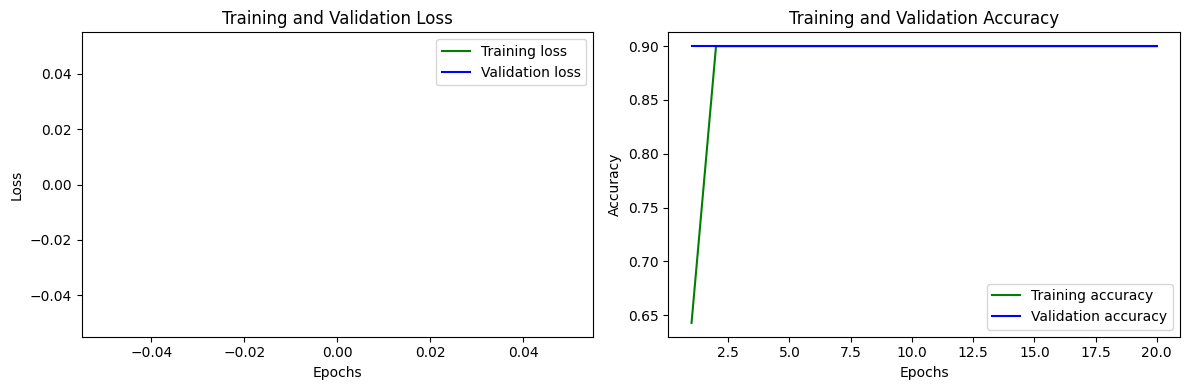

In [57]:
# Adjust the values to train
num_classes = num_classes
epochs = 100
learning_rate = 0.001
threshold = 0.5
early_stopping_patience = 20

cnn = CNN(num_classes, epochs, learning_rate, threshold, early_stopping_patience)
cnn.train(x_train, y_train, x_val, y_val)